## Training coffee ESM using MaxEnt
- Methodology: https://doi.org/10.1371/journal.pone.0124155

## Load coffee presence observations
- Source: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/29634

In [1]:
import pandas as pd
df = pd.read_csv("../data/raw/dataverse_files/CoffeePoints_2.csv", encoding='latin-1')
df

,Taxon,Longitude,Latitude,Country,ADM1_NAME,ADM2_NAME
0,coffee,-51.062493,-23.854165,Brazil,Parana,Tamarana
1,coffee,-50.729160,-23.687498,Brazil,Parana,Sao Jeronimo Da Serra
2,coffee,-50.687493,-23.687498,Brazil,Parana,Sao Jeronimo Da Serra
3,coffee,-50.604160,-23.687498,Brazil,Parana,Sao Jeronimo Da Serra
4,coffee,-51.437493,-23.520831,Brazil,Parana,Apucarana
...,...,...,...,...,...,...
2189,coffee,101.520848,22.354171,China,Yunnan Sheng,Xishuangbanna Dai
2190,coffee,101.020848,22.562504,China,Yunnan Sheng,Xishuangbanna Dai
2191,coffee,97.895848,24.729171,China,Yunnan Sheng,Dehong Dai Jingpo
2192,coffee,98.895848,24.854171,China,Yunnan Sheng,Baoshan


In [2]:
import elapid as ela
import geopandas as gpd

geometry = ela.xy_to_geoseries(
    x=df['Longitude'],
    y=df['Latitude']
)

# then merge the two together into a GeoDataFrame
coffee = gpd.GeoDataFrame(df[["Taxon"]], geometry=geometry)
coffee

,Taxon,geometry
0,coffee,POINT (-51.06249 -23.85416)
1,coffee,POINT (-50.72916 -23.68750)
2,coffee,POINT (-50.68749 -23.68750)
3,coffee,POINT (-50.60416 -23.68750)
4,coffee,POINT (-51.43749 -23.52083)
...,...,...
2189,coffee,POINT (101.52085 22.35417)
2190,coffee,POINT (101.02085 22.56250)
2191,coffee,POINT (97.89585 24.72917)
2192,coffee,POINT (98.89585 24.85417)


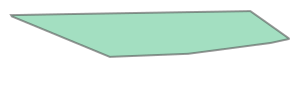

In [66]:
coffee.unary_union.convex_hull

/var/folders/wb/v7frq16s6nnb0tkx5j8nz06r0000gn/T/ipykernel_31499/2006986897.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


<Axes: >

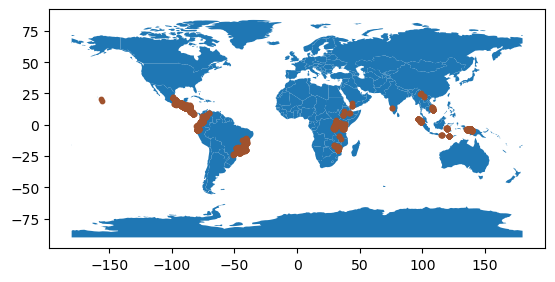

In [3]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ax = world.plot()
coffee.plot(ax=ax, color='sienna', markersize=10)

## Load BIOCLIM environmental rasters
- Source: https://www.worldclim.org/data/bioclim.html
- 8640x4320 native resolution

In [4]:
import glob
rasters = glob.glob('../data/raw/wc2.1_2.5m_bio/*')
labels = [r[38:-4] for r in rasters]
background = ela.sample_raster(rasters[0], count=10000, ignore_mask=True)

<Axes: >

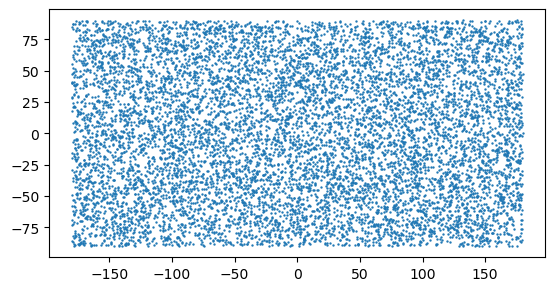

In [5]:
background.plot(markersize=0.5)

In [6]:
merged = ela.stack_geodataframes(coffee, background, add_class_label=True)
annotated = ela.annotate(merged, rasters, drop_na=True, quiet=True)
x = annotated.drop(columns=['class', 'geometry'])
y = annotated['class']

In [7]:
model = ela.MaxentModel(transform='cloglog', beta_multiplier=2.0)
model.fit(x, y)

MaxentModel(beta_multiplier=2.0)

In [8]:
import sklearn.metrics as metrics
ypred = model.predict(x)
auc = metrics.roc_auc_score(y, ypred)
print(f"Training AUC score: {auc:0.3f}")

Training AUC score: 0.994


In [12]:
fig, ax = model.partial_dependence_plot(x, labels=labels, dpi=100)

KeyError: 'values'

In [22]:
ela.save_object(model, '../models/first-maxent-model.ela')

In [3]:
import rasterio as rio
import elapid as ela
output_raster = 'first-maxent-predictions.tif'
# ela.apply_model_to_rasters(model, rasters, output_raster, quiet=True)

# and read into memory
with rio.open(output_raster, 'r') as src:
    pred = src.read(1, masked=True)

In [4]:
pred.shape

(4320, 8640)

In [ ]:
import holoviews as hv
hv.extension("bokeh", "matplotlib")
hv.Image(pred).opts(cmap='plasma', colorbar=True, width=800, height=400)

<Axes: >

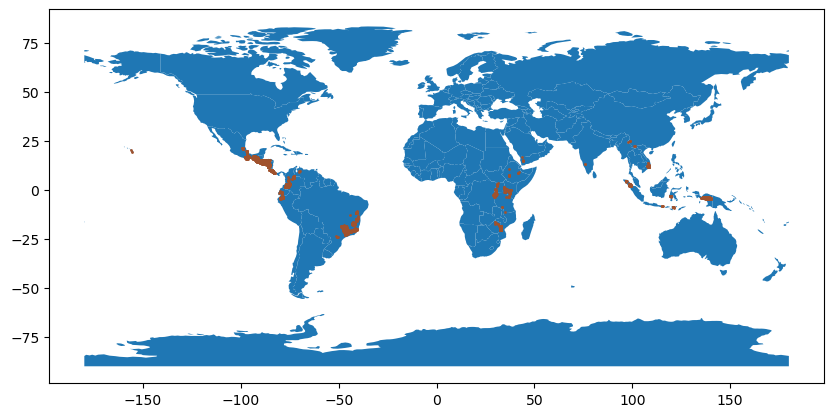

In [29]:
ax = world.plot(figsize=(10, 6))
coffee.plot(ax=ax, color='sienna', markersize=1)

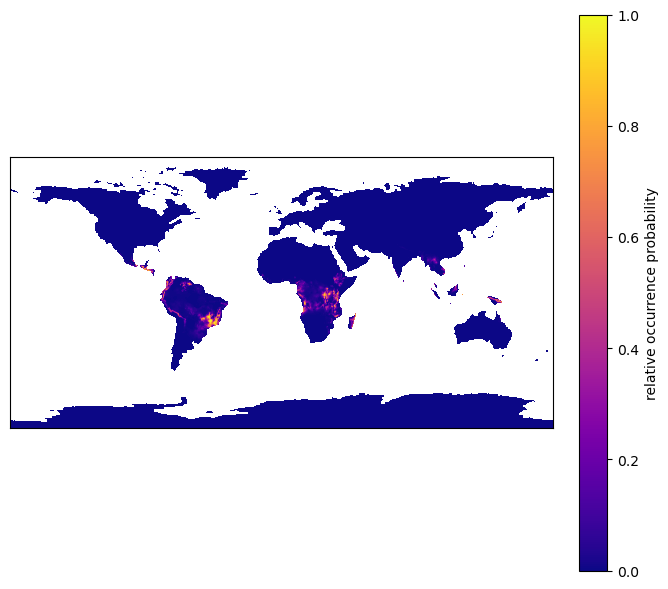

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(7, 6), dpi=100)
plot = ax.imshow(pred, vmin=0, vmax=1, cmap='plasma')
ax.set_xticks([])
ax.set_yticks([])
cbar = plt.colorbar(plot, ax=ax, label="relative occurrence probability", pad=0.04)
plt.tight_layout()